In [56]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [ ]:
# ============================================
# 2. LOAD DATA
# ============================================
# Replace with your dataset path
df = pd.read_csv("data/jobs_salaries_2023.csv")

# Quick look
print(df.head())
print(df.info())
print(df.describe())

   work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

     salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000.0             EUR        85847.0                 ES           100   
1   30000.0             USD        30000.0                 US           100   
2   25500.0             USD        25500.0                 US           100   
3  175000.0             USD       175000.0                 CA           100   
4  120000.0             USD       120000.0                 CA           100   

  company_location company_size  
0               ES            L  
1     

In [58]:
# ============================================
# 3. DATA CLEANING
# ============================================
# Drop rows with missing salary_in_usd
df = df.dropna(subset=["salary_in_usd"])

# Drop unused columns if any (keep salary prediction relevant ones)
# work_year is constant = 2023 in your dataset, so drop it
df = df.drop(columns=["work_year", "salary", "salary_currency"])

# Check unique job titles and locations
print("Unique job titles:", df["job_title"].nunique())
print("Unique company locations:", df["company_location"].nunique())

Unique job titles: 69
Unique company locations: 58


In [ ]:
# ============================================
# 4. FEATURE ENGINEERING
# ============================================
# Load country codes and names
countries = pd.read_csv("data/countries.csv")

# Create dictionary for fast mapping
country_dict = dict(zip(countries["code"], countries["name"]))

# Map codes to names for employee and company
df["employee_residence_name"] = df["employee_residence"].map(country_dict)
df["company_location_name"] = df["company_location"].map(country_dict)

# Create feature: same_country (1 if employee and company locations match)
df["same_country"] = (
    df["employee_residence_name"] == df["company_location_name"]
).astype(int)

# Define features and target
X = df.drop(columns=["salary_in_usd"])
y = df["salary_in_usd"]

# Identify categorical and numeric columns
categorical_cols = [
    "experience_level",
    "employment_type",
    "job_title",
    "employee_residence",
    "company_location",
    "company_size",
]
numeric_cols = ["remote_ratio", "same_country"]

In [60]:
# ============================================
# 5. SPLIT DATA
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [61]:
# ============================================
# 6. PREPROCESSING PIPELINE
# ============================================
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

In [62]:
# ============================================
# 7. BASELINE MODEL: LINEAR REGRESSION
# ============================================
import joblib

lr_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", root_mean_squared_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

# ============================================
# SAVE MODEL TO PKL
# ============================================
joblib.dump(lr_model, "models/linear_regression_salary_model.pkl")
print("Model saved to linear_regression_salary_model.pkl")

Linear Regression Performance:
MAE: 34628.60430695857
RMSE: 48035.47436838099
R²: 0.4718846585076898
Model saved to linear_regression_salary_model.pkl


In [63]:
# ============================================
# 8. ADVANCED MODEL: RANDOM FOREST REGRESSOR
# ============================================
import joblib

rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=200, random_state=42)),
    ]
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

# ============================================
# SAVE MODEL TO PKL
# ============================================
joblib.dump(rf_model, "models/random_forest_salary_model.pkl")
print("Model saved to random_forest_salary_model.pkl")


Random Forest Performance:
MAE: 34215.620037774395
RMSE: 48287.26304634246
R²: 0.46633367892572297
Model saved to random_forest_salary_model.pkl


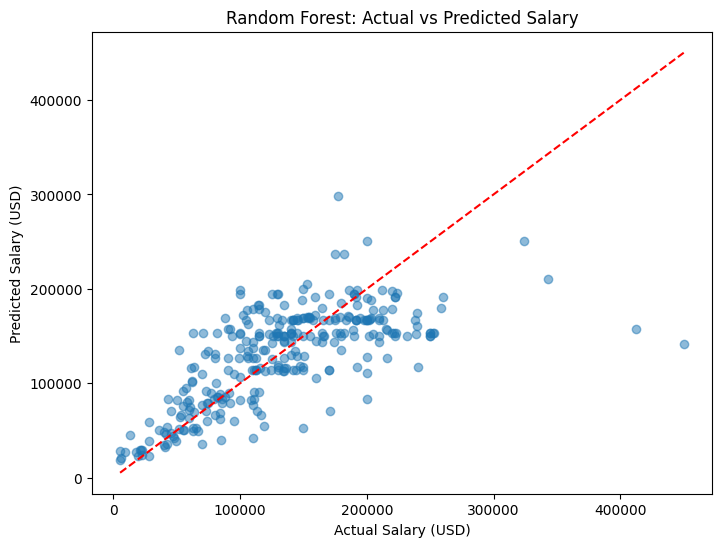

In [64]:
# ============================================
# 9. VISUALIZATIONS
# ============================================
# Compare predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Random Forest: Actual vs Predicted Salary")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

/var/folders/jh/z981c7zj0vz0gmyfc8mhdxdr0000gn/T/ipykernel_19733/1815608992.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary.values, y=avg_salary.index, palette="viridis")


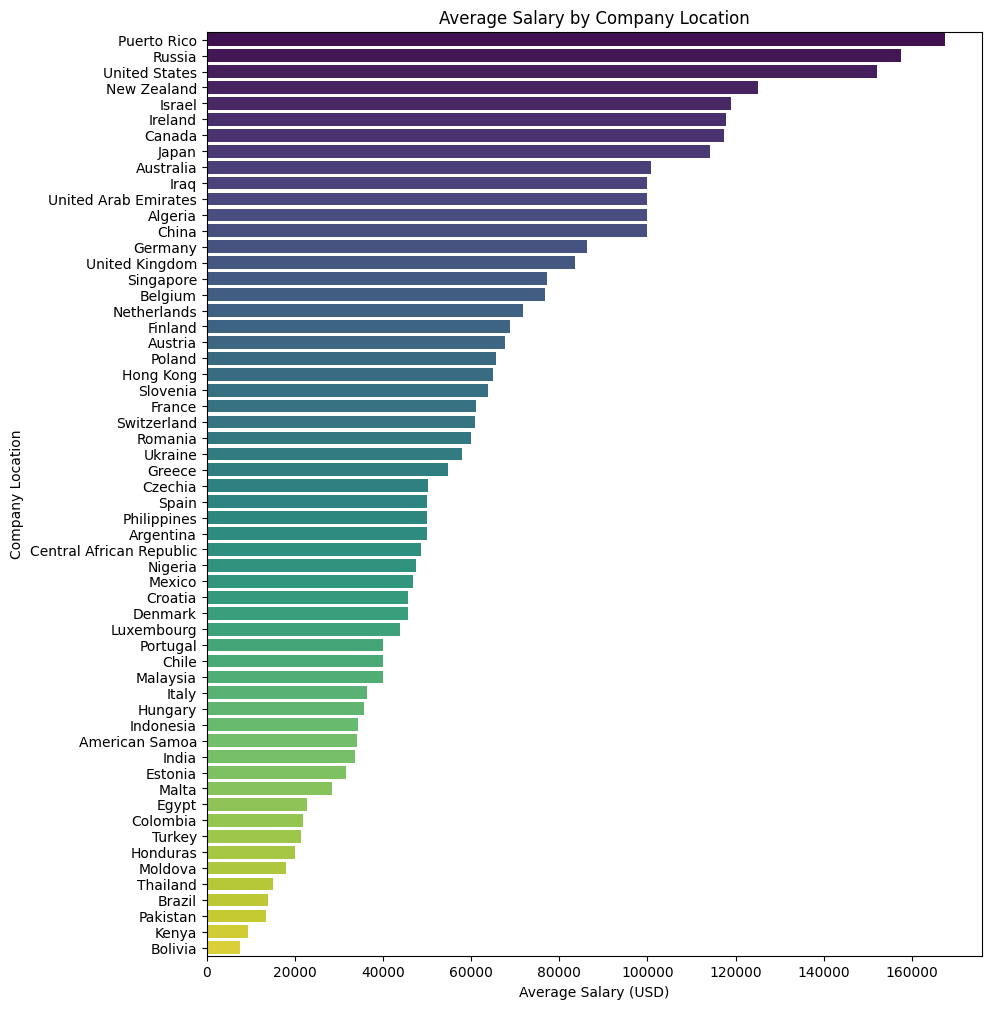

In [66]:
# Average salary by company location
plt.figure(figsize=(10, 12))
avg_salary = (
    df.groupby("company_location_name")["salary_in_usd"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=avg_salary.values, y=avg_salary.index, palette="viridis")
plt.title("Average Salary by Company Location")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Company Location")
plt.show()